In [1]:
import random
import time
import os
import datetime
import itertools
import math
import sys
import pickle
import warnings
from random import randint

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [3]:
if IN_COLAB:
  COLAB_BASE_DIR = "/content/gdrive/MyDrive/Universidad/VIU/TFM/notebooks/"
  from google.colab import drive
  drive.mount('/content/gdrive/')
  sys.path.append(os.path.join(COLAB_BASE_DIR, 'SkyGPT'))
  sys.path.append(os.path.join(COLAB_BASE_DIR, 'common'))

In [4]:
if IN_COLAB:
  if not os.path.exists("/data/video_prediction_dataset.hdf5"):
    !gdown 1fYtaFcGKSL8ykJFbewAFsFf9C4aW0DuV
    !gdown 1VILdkCRWsDTrN9DPeMLh8jlibAoBLzy-
    !gdown 197pDAI8KVsiDAA1xaPbitZpmvzh9CDqT
    !gdown 1XqgXAtxWUdnBJnvQTtEr8JpBkVi3JuSC
    !gdown 1_DVttDvwxCm_QGDxU2tbaaclWKd1VCau
    !gdown 1QkqsqjYhdJbqf2HUOQXwroYaO0uOLUPm
    %mkdir -p /data
    %mv /content/*.hdf5 /data/
    %mv /content/*.npy /data/
    %mv /content/*.png /data/

In [5]:
import argparse
import torch
import matplotlib.pyplot as plt

import os.path as osp

import glob
import h5py
import numpy as np

import torch.utils.data as data
import torch.nn.functional as F
import torch.distributed as dist
from torchvision.datasets.video_utils import VideoClips
import pytorch_lightning as pl

import xarray as xr

# from videogpt import VideoData, VideoGPT, load_videogpt
from videogpt import VideoGPT, load_videogpt
from videogpt.utils import save_video_grid

if not IN_COLAB:
  sys.path.append('../common')
import common

In [6]:
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
data_folder = os.path.join(pardir,'data')
data_path = os.path.join(data_folder,'video_prediction_dataset.hdf5')
mask_path = os.path.join(data_folder,'mask_black_skygptdata.png')
model_name = 'ConvLSTM'
output_path = os.path.join(cwd, "save", f"{model_name}.torch")
IN_COLAB = False
if IN_COLAB:
  output_path = os.path.join(COLAB_BASE_DIR, "ConvLSTM", f"{model_name}.torch")
with h5py.File(data_path, 'r') as fds:
    group_names = list(fds.keys())
    print(group_names)

dss = {}
for gname in group_names:
    dss[gname] = xr.open_dataset(data_path, group=gname)

['test', 'trainval']


In [7]:
def getNP(tensor, idx):
    output = tensor[idx,:,:,:,:]
    output = output.permute(1,2,3,0)
    output = output.cpu()
    return output.numpy()

In [8]:
def preprocess(video, resolution, sequence_length=None):
    # video: THWC, {0, ..., 255}
    video = video.permute(0, 3, 1, 2).float() / 255. # TCHW
    t, c, h, w = video.shape

    # temporal crop
    if sequence_length is not None:
        assert sequence_length <= t
        video = video[:sequence_length]

    # scale shorter side to resolution
    scale = resolution / min(h, w)
    if h < w:
        target_size = (resolution, math.ceil(w * scale))
    else:
        target_size = (math.ceil(h * scale), resolution)
    video = F.interpolate(video, size=target_size, mode='bilinear',
                          align_corners=False)

    # center crop
    t, c, h, w = video.shape
    w_start = (w - resolution) // 2
    h_start = (h - resolution) // 2
    video = video[:, :, h_start:h_start + resolution, w_start:w_start + resolution]
    video = video.permute(1, 0, 2, 3).contiguous() # CTHW

    video -= 0.5

    return video


class HDF5Dataset:
    """ Generic dataset for data stored in h5py as uint8 numpy arrays.
    Reads videos in {0, ..., 255} and returns in range [-0.5, 0.5] """
    def __init__(self, data_file, sequence_length, train=False, resolution=64):
        """
        Args:
            data_file: path to the pickled data file with the
                following format:
                {
                    'train_data': [B, H, W, 3] np.uint8,
                    'train_idx': [B], np.int64 (start indexes for each video)
                    'test_data': [B', H, W, 3] np.uint8,
                    'test_idx': [B'], np.int64
                }
            sequence_length: length of extracted video sequences
        """
        super().__init__()
        self.train = train
        self.sequence_length = sequence_length
        self.resolution = resolution

        # read in data
        self.data_file = data_file
        self.data = h5py.File(data_file, 'r')
        self.prefix = 'train' if train else 'test'
        self._images = self.data[f'{self.prefix}_data']
        self._idx = self.data[f'{self.prefix}_idx']
        self.size = len(self._idx)

    def setstate(self, state):
        self.__dict__ = state
        self.data = h5py.File(self.data_file, 'r')
        self._images = self.data[f'{self.prefix}_data']
        self._idx = self.data[f'{self.prefix}_idx']

    def getitem(self, idx):
        start = self._idx[idx]
        end = self._idx[idx + 1] if idx < len(self._idx) - 1 else len(self._images)
        assert end - start >= 0
        start = start + np.random.randint(low=0, high=end - start - self.sequence_length + 1) #Andea added +1 for inclusive of endpoint
        assert start < start + self.sequence_length <= end
        video = torch.tensor(self._images[start:start + self.sequence_length])
        return dict(video=preprocess(video, self.resolution), idx=idx)
#         return dict(video=preprocess(video, self.resolution))


## AAA

In [9]:
#%%capture
%pip install torch torchvision h5py xarray matplotlib

Note: you may need to restart the kernel to use updated packages.


In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.utils.data as data
from torch.utils.data import DataLoader
import numpy as np
import h5py
import PIL.Image
from IPython.core import display as idisplay
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xarray as xr


In [11]:
device='cpu'

In [12]:
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
data_folder = os.path.join(pardir,'data')
data_path = os.path.join(data_folder, 'video_prediction_dataset.hdf5')
mdata_path = os.path.join(data_folder, 'masked_clouds.hdf5')
model_name = 'SkyGPTtest'
output_path = os.path.join(cwd, "save", f"{model_name}.torch")
if IN_COLAB:
  output_path = os.path.join(COLAB_BASE_DIR, "SkyGPT", f"{model_name}.torch")
with h5py.File(data_path, 'r') as fds:
    group_names = list(fds.keys())
    print(group_names)
    fds.close()


dss = {}
for gname in group_names:
    dss[gname] = xr.open_dataset(data_path, engine='netcdf4', group=gname)#, phony_dims='sort')

['test', 'trainval']


In [13]:
mask_png = np.array(PIL.Image.open(mask_path).resize((64, 64)).getdata())
# Mask for size 64
print(mask_png.shape)
mask_to_black = (mask_png[:,3] > 127)
not_mask_to_black = (mask_png[:,3] <= 127)
print(mask_to_black.sum()) # alpha = 1 = black visible
print(not_mask_to_black.sum())
print(not_mask_to_black.sum()+mask_to_black.sum())
mask_to_black = mask_to_black.reshape((64, 64))
empty_mask = np.ones((64, 64, 3))
mask_to_black = np.where(np.expand_dims(mask_to_black, 2), empty_mask, empty_mask*0)


(4096, 4)
1674
2422
4096


In [14]:
bs = 16 # batch size
transform = transforms.Compose([
    transforms.Lambda(lambda x: np.where(mask_to_black, x*0, x)),
    #v2.functional.adjust_contrast(),
    transforms.ToPILImage(), # This already normalizes the image
    transforms.Lambda(v2.functional.autocontrast),
    transforms.Resize(64),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x.float()),
    #transforms.Normalize(mean=[0.5], std=[0.5])  # Example normalization
])
# Create Dataset and DataLoader
train_dataset = common.VideoDataset(dss['trainval']['images_log'], dss['trainval']['images_pred'], transform=transform, stack_videos=True, device=device)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

test_dataset = common.VideoDataset(dss['test']['images_log'], dss['test']['images_pred'], transform=transform, stack_videos=True, device=device)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Number of videos: {len(train_dataset.videos)}.")
print(f"Number of video batches: {len(train_loader)}")
print(f"Size of video batches: {bs}.")

Number of videos: 53336.
Number of video batches: 3334
Size of video batches: 16.


In [15]:
def open_videodataset(data_file: str, seq_len: int):
    train_dataset.getitem = lambda x: train_dataset.__getitem__(x)[:seq_len]
    return train_dataset

## AAS

In [16]:
def getSample(ckpt_path, n, start, data_file):
    
    batch = {}
    if not os.path.exists(ckpt_path):
        gpt = load_videogpt(ckpt_path)
    else:
        gpt = VideoGPT.load_from_checkpoint(ckpt_path)
    #gpt = gpt.cuda()
    gpt.eval()

    sequence_length = 16
    train=False
    resolution=64


    #data = HDF5Dataset(data_file, sequence_length, train, resolution)
    data = open_videodataset(data_file, sequence_length)
    #tempBatch = torch.empty((n, 3, 16, 64, 64), device = 'cuda')
    tempBatch = torch.empty((n, 3, 16, 64, 64), device = 'cpu')

    for pos, example in enumerate(range(start, start+n)):
        item = data.getitem(example)
        #tempBatch[pos] = item['video']
        tempBatch[pos] = item.permute((1, 0, 2, 3))

    batch['video'] = tempBatch

    samples = gpt.sample(n, batch)
    return samples

In [17]:
def runIteration(ckpt_path, num_test, n, it, save_folder, data_file):
    all_test_samples = np.empty([num_test, 16, 64, 64, 3]) #initialize a holder for the sample results (diff from sample shape)

    step = n
    for batch_start in range(0, num_test, step):

        start = batch_start

        #check for partial batch at end
        if (start + step) > num_test:
            n = num_test - start

        output = getSample(ckpt_path, n, start, data_file)
        output = output.permute(0,2,3,4,1) #original shape is (num_examples, 3, 16, 64, 64)
        output = output.cpu()
        output = output.numpy()
        all_test_samples[start:(start+n)] = output
    filename = save_folder + "/sample_" + str(it) + ".npy"
    np.save(filename, all_test_samples)

In [18]:
num_test = 2582 # number of samples in the dataset
num_test = 2
n = 1#50 # num of futures to be generated for each sample
#ckpt_path = '/scratch/groups/abrandt/solar_forecasting/GAN_project_new/models/VideoGPT/trained_models/PhyGPT_full_2min/lightning_logs/version_36584693/checkpoints/epoch=17-step=30005.ckpt'
ckpt_path = 'bair_gpt'
#data_file = 'GPT_full_2min_2019_test_data.hdf5'
#data_file = 'GPT_benchmark.hdf5'
data_file = '../../data/video_prediction_dataset.hdf5'

In [19]:
#save_folder = "/scratch/groups/abrandt/solar_forecasting/GAN_project_new/models/PhyGPT/inference/PhyGPT4x4x4_2019_test"
save_folder = "save"
if os.path.isdir(save_folder)==False:
    os.makedirs(save_folder)
print(save_folder)

save


In [20]:
num_it = 50
for it in range(45, num_it):
    runIteration(ckpt_path, num_test, n, it, save_folder, data_file)
    print('Iteration ', it, 'complete!')

/home/javgat/VIU/TFM/presente/.venv/lib/python3.8/site-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
Lightning automatically upgraded your loaded checkpoint from v1.3.3 to v2.3.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../.cache/videogpt/bair_gpt`
Lightning automatically upgraded your loaded checkpoint from v1.1.1 to v2.3.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../.cache/videogpt/bair_stride4x2x2`
100%|██████████| 4096/4096 [03:43<00:00, 18.29it/s]
Lightning automatically u

Iteration  45 complete!


Lightning automatically upgraded your loaded checkpoint from v1.3.3 to v2.3.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../.cache/videogpt/bair_gpt`
Lightning automatically upgraded your loaded checkpoint from v1.1.1 to v2.3.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../.cache/videogpt/bair_stride4x2x2`
 92%|█████████▏| 3771/4096 [03:32<00:18, 17.72it/s]


KeyboardInterrupt: 

In [22]:
dat = np.load(save_folder + "/sample_" + str(45) + ".npy")

In [25]:
print(dat.shape)

(2, 16, 64, 64, 3)


In [26]:
def show(img):
    f = plt.figure(figsize=(12, 12), layout='tight')
    ncols = len(img)//4 if len(img) % 4 == 0 else len(img)//4 + 1
    axarr = f.subplots(4,4)
    for i in range(len(img)):
        axarr[i//4][i%4].set_axis_off()
        axarr[i//4][i%4].imshow(img[i])
    plt.show()

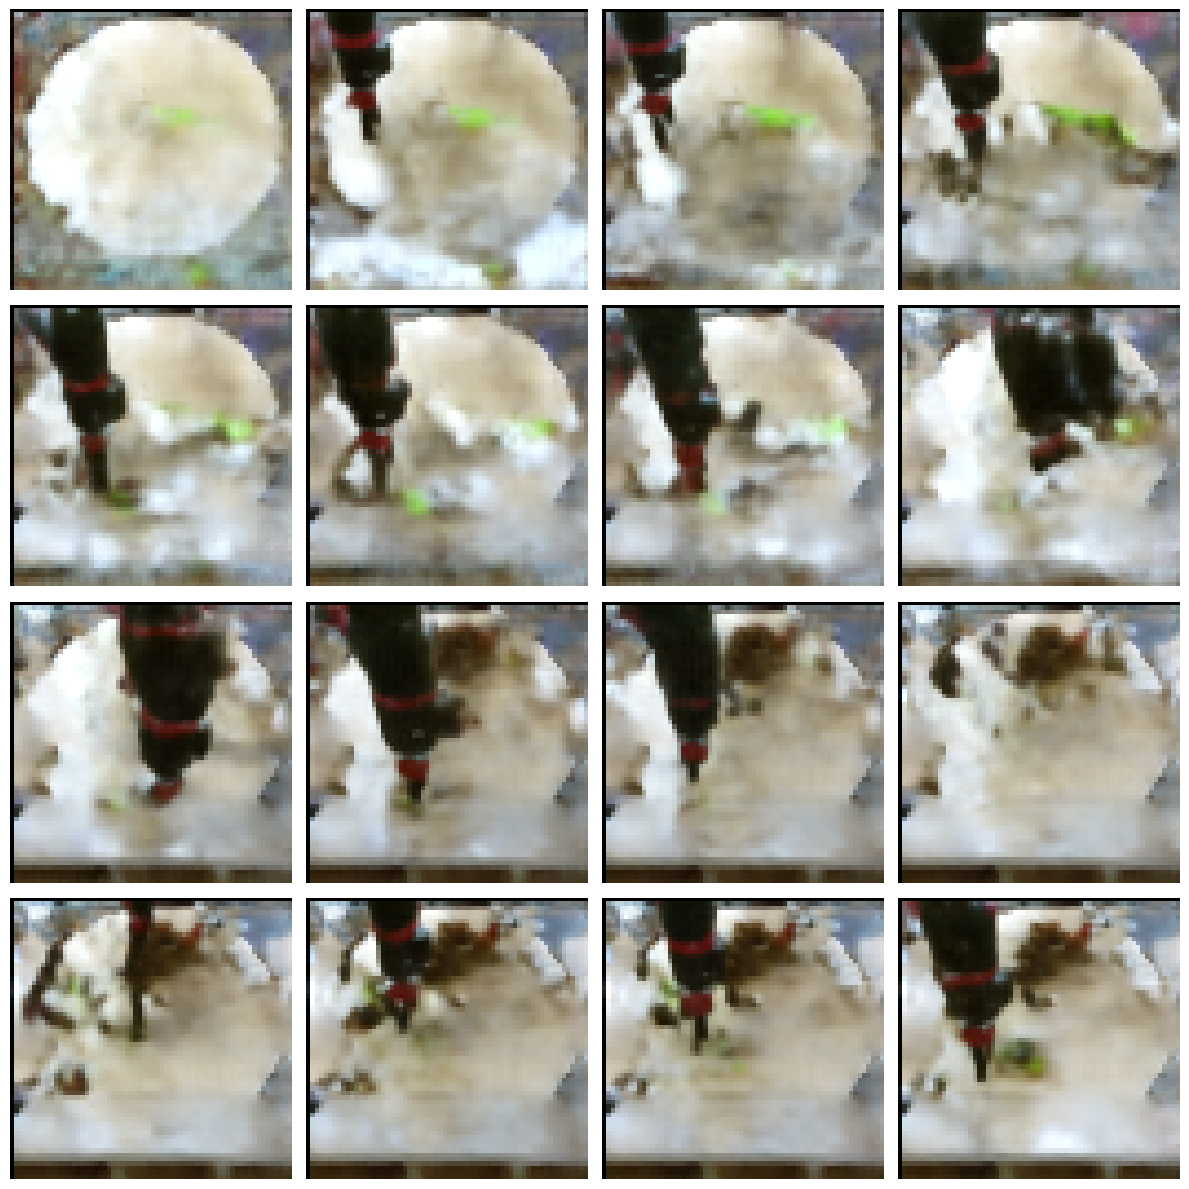

In [28]:
show(dat[1])